# Fundamentals of Data Analysis - Regression Project

This is Brian Doheny's project submission for the Fundamentals of Data Analysis 2020 module at Galway-Mayo Insitute of Technology.

## Contents
* [Introduction](#introduction)
* [Exploratory Data Analysis](#eda)
* [Train-Test Split](#tts)
* [Linear Regression](#linear)
* [Polynomial Regression](#polynomial)
* [Measuring Model Performance](#performance)
* [Decision Tree Regression](#tree)
* [K-Nearest Neighbors Regression](#knn)
* [References & Resources](#references)

<a id='introduction'></a>
## Introduction

In this Jupyter Notebook, I will be analysing a dataset containing the power output (measured in kilowatts (kW)) of a wind turbine at various wind speeds (measured in metres per second (m/s)). I will be applying multiple forms of regression analysis on this dataset so as to find an accurate method of predicting the output at a given windspeed, using the existing dataset as the base for my regression models.

Before I get into the regression analysis, I will begin by conducting some exploratory data analysis on the dataset so as to deepen my understanding of the data available.

<a id='eda'></a>
## Exploratory Data Analysis

Exploratory data analysis (EDA) should be the first step in any analysis of a dataset, as it allows one to get to grips with the data at hand. By taking the time to understand the variables available the user will be better placed to make decisions on how to deal with outliers or null values, what type of algorithms will make most sense for the dataset, and which variables are useful for the intended analysis, and which can be excluded. It will also help the user to spot any missing data before they get too far into their analysis, and may save lots of time down the road[1].

I'll begin by loading our dataset (turbine_output.csv) into a pandas DataFrame, and taking a look at the first few rows of the DataFrame, as well as the summary statistics for the two columns. This will give a better idea of what type of data is in the csv, for example are the data points discrete (integers) or continuous (floating point numbers), and what the range is.

In [1]:
#Importing the packages I'll be using for Exploratory Data Analysis.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Loading the CSV to a Pandas DataFrame.
power_output_df = pd.read_csv('turbine_output.csv')

#Printing the first 5 rows.
power_output_df.head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


In [3]:
#Looking at summary statistics of the DataFrame.
power_output_df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


From this I can see that the dataset has 500 datapoints, with no missing values (or at least any missing measurements have a value entered). 

The speed column ranges from 0m/s to 25m/s, and as we can see from the 25th, 50th and 75th percentiles, this column appears to be linearly spaced across that range. The speed is measured as a floating point number, so we have a continuous variable.

Meanwhile the power column ranges from 0 to 113.556. 25% of the dataset is at 5.288 or less, and 50% is at 41.6455 or less, so we know this column is not linearly spaced, and the the measurements are skewed to the lower end of the range. Like speed, the power column is also a continuous variable as shown by the floating point numbers. 

From this, I can already see that the speed:output relationship is not a 1:1 relationship, and that at some point the output grows faster than the speed. This is because the range for speed is consistent, but the range for power grows rapidly after the median. Therefore, I already know a linear regression will not fit this dataset perfectly.

I will now use some plots to visualize this dataset. As exploratory data analysis is supposed to be a learning opportunity for the analyst, the visualizations at this stage are not intended to be presentation ready. However as I will be making multiple plots of the same dataset throughout this notebook, I will create a function for styling my plots.

In [4]:
#Creating a function for general formatting of my plots.
def format_plots(ax, title, hist=False):
    '''Edits the presentation of plots via Matplotlib. 
    Takes an ax object and title (string).
    Returns the same ax object with text formatted, top and right axes hidden, and axes color changed to grey.'''

    #Stating the hex code for the grey I will be using.
    grey = '#808080'
        
    #Aligns the title to the left axis.        
    fig.suptitle(title, x=0.125, y = 0.95, fontsize = 12, ha='left', color = grey, fontweight = 'bold')

    #Using fig.text for the axis labels as it gives more flexibility.
    #Hiding any default x and y axis labels.
    ax.set_ylabel('')    
    ax.set_xlabel('')
    
    #Default to these axis labels unless it hist is set to True.
    if hist == False:
        #Placing and formatting the x axis label
        fig.text(0.125, 0.03, 'Speed (m/s)', ha='left', color = grey)

        #Placing and formatting the y axis label
        fig.text(0.12, 0.9, 'Power Output (kW)', ha='right', color = grey)
    else:
        pass
    #Edit the spines, so that we can highlight the data in the plot itself.
    #Hiding the right and top axes.
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    #Changing the left and bottom axes to use the grey colour stated above.
    ax.spines['left'].set_color(grey)
    ax.spines['bottom'].set_color(grey)
    ax.tick_params(axis='both', colors=grey)

    return ax

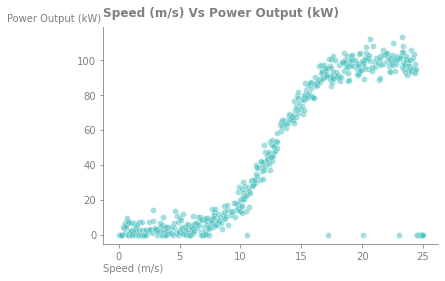

In [5]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x = power_output_df.speed, y = power_output_df.power, alpha = 0.5, color = '#47C1BF')
format_plots(ax, 'Speed (m/s) Vs Power Output (kW)')
ax;

Immediately we can see an "S" shaped curve on the dataset, so a linear regression will definitely not fit this dataset perfectly. There is the appearance of a linear relationship when the speed is between 7m/s and 18m/s, but the power output then appears to peak or grow much slower.

We can also see a few clear outliers in the dataset, with output being recorded as being 0 kW at around 17m/s, 20m/s and 23 m/s. The concentration of 0's around 25m/s is also something I will need to keep in mind as they will have an impact on any regression analysis I conduct.

To get a better idea of the spread of values in the power column, I will plot a histogram.

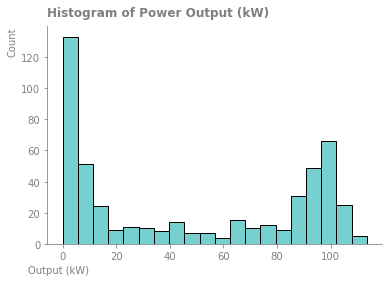

In [6]:
fig, ax = plt.subplots()
ax = sns.histplot(power_output_df.power, bins = 20, color = '#47C1BF')
format_plots(ax, 'Histogram of Power Output (kW)', hist=True)
ax.set_xlabel('Output (kW)', position = (0.125, 0.03), ha = 'right', color = '#808080')
ax.set_ylabel('Count', position = (0.12, 1), ha = 'right', color = '#808080')
ax;

A clear concentration of measurements around 0kW, as expected from the scatter plot above. We also see measurements gathering around 100kW, which ties in with the plateauing of output that was suggested too.

I will do another histogram, this time slicing the dataframe to show those observations where the power is equal to 0, and looking at the speed values in the resulting slice.

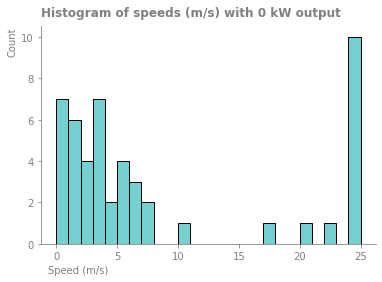

In [7]:
fig, ax = plt.subplots()
ax = sns.histplot(power_output_df.loc[power_output_df['power'] == 0.00].speed, bins = 25, color = '#47C1BF')
format_plots(ax, 'Histogram of speeds (m/s) with 0 kW output', hist=True)
ax.set_xlabel('Speed (m/s)', position = (0.2, 0.03), ha = 'right', color = '#808080')
ax.set_ylabel('Count', position = (0.12, 1), ha = 'right', color = '#808080')
ax;

Observations where power output is equal to 0kW are common at the lower speed values, however after 8m/s they become sparse until 24m/s. This strongly suggests that something happens to the wind turbine once wind speed is around 24 m/s, and so I will not be counting those values as outliers. 

However, the measurements at around 11m/s, 17m/s, 20m/s and 22m/s could well be outliers - either due to missing observations or some sort of error. For example if we look at the 17m/s observations:
* 17.117m/s output = 91.270kW
* 17.142m/s output = 95.622kW
* 17.167m/s output = 0.000kW
* 17.267m/s output = 100.831kW
* 17.317m/s output = 96.970kW

This measurement at 17.167m/s appears to be an outlier. There's a few reasons this may have come about. It's possible that there was a malfunction that prevented the measurement being captured. It may also be that the wind speeds were pre-determined and there hasn't been an opportunity to measure the windspeed at 17.167m/s.

These measurements will impact my regressions, so I will therefore be excluding those four data points from my analysis.

In [8]:
#Method for dropping rows based on multiple conditions found on StackOverflow[2].
cleaned_df = power_output_df.drop(power_output_df.loc[(power_output_df['power'] == 0.00) & (power_output_df['speed'] > 10.0) & (power_output_df['speed'] < 24.0)].index)

Now to confirm that only the four data points mentioned above were removed, I will plot that histogram again.

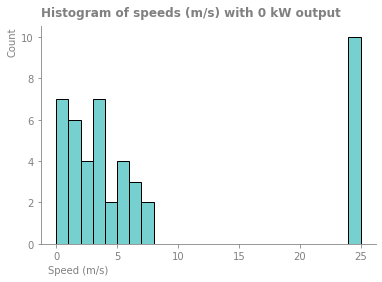

In [9]:
fig, ax = plt.subplots()
ax = sns.histplot(cleaned_df.loc[cleaned_df['power'] == 0.00].speed, bins = 25, color = '#47C1BF')
format_plots(ax, 'Histogram of speeds (m/s) with 0 kW output', hist=True)
ax.set_xlabel('Speed (m/s)', position = (0.2, 0.03), ha = 'right', color = '#808080')
ax.set_ylabel('Count', position = (0.12, 1), ha = 'right', color = '#808080')
ax;

With those outliers removed, I can now move onto the next stage - splitting the dataset into a training set and a testing set.

<a id='tts'></a>
## Train-Test Split

The goal of this regression analysis is to find a model that will accurately predict the power output at a given windspeed. As I do not have a way to gather new observations to test any model that I test on this dataset, I'll therefore have to split the dataset into a training set and a testing set. This process is known as "Train-Test Split".

Train-Test Split divides the original dataset into two subsets, and as the name suggests, one of these will be for "training" the model, and the other for testing it's accuracy[3]. How share of the dataset is used for training and what share for testing is up to the user to decide, and in this scenario I will be using 80% for training and 20% for testing. This is because at 496 observations (the original 500 minus the 4 outliers I've removed), the dataset isn't particularly large, so I must keep as much of it for training as possible, otherwise there won't be enough data points for any model to be accurate. This will leave me with 20% for testing the accuracy of the various regression models, and will offer some way for us to compare their performance.

In order to do this, I will utilize the train_test_split() function available from Scikit-Learn[4]. Before doing so, I must split the dataset into two arrays, one containing just the speed variable (X), and the other containing just the power (y).

In [10]:
X = cleaned_df['speed']
y = cleaned_df['power']

ind_X = np.argsort(X, axis=1)
ind_y = np.argsort(y, axis=1)

I can now split both X and y into training and testing sets via sklearn.model_selection. As mentioned previously, I will be keeping 20% of the dataset for testing, with the rest used for training the model. I will also be setting random_state to 33 so as to keep my results consistent on each run of this notebook.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 33)

I can check the shape of the X_train and X_test arrays to see if their shares of the original dataset are 80% and 20% respectively.

In [12]:
X_train.shape

(396,)

In [13]:
X_test.shape

(100,)

With the dataset now split into a training set and a testing set, I can now move onto the regression analysis.

<a id='linear'></a>
## Linear Regression

Simple Linear Regression, also known as univariate linear regression, is the act of using a line of best fit to highlight the relationship between a variable (x) and its result (y). In this example, we are looking at what relationship windspeed (x) has on the power output (y) for a wind turbine. This line of best fit will give the user some indication of the relationship (if any), and can help the user to predict roughly what y will be for any given value of x. This line can generally be summed up as:
```
y = mx + c
```
Where y is the result we're looking to work out. x is the variable that we know has an effect on y. m shows us the slope of the line, i.e. how quickly the y values will increase or decrease as x changes. And c is the y-intercept, that is to say, what the y value would be if x is equal to 0.

That said, it should be stressed that this line will rarely be exact, as we are trying to find the line that best sums up the relationship to the data as a whole, and so it may not match perfectly for any one pair of data points. The line is balanced between all of the data points with the aim of minimizing the overall difference between the data points and where the line is placed. This means that any outliers, positive or negative, can have a larger influence on the placing of the line. 

One way to describe this is to think of the line as being a piece of wood held in place by springs[5] (the data points) above and below it. Those springs closes to the wood apply some force on it, and so they impact the angle of the slop to some degree, however the springs that are furthest away will be applying the most force to the wood and thus have the largest impact on the angle of the slope.

From our exploratory data analysis, we can already see that this data set is not ideally suited to fitting a line, as it has more of an S shape to it, rather than a straight linear relationship. We can see that the power generation stays close to 0kW until wind speed is around 7m/s, at which point we see what looks like a linear relationship until windspeed hits 18m/s at which point power generation then appears to be plateau at around 100kW.

Nonetheless, we can attempt to fit a line to this data to really highlight that there isn't a truly linear relationship between the two variables. As a reminder, here is the training dataset:

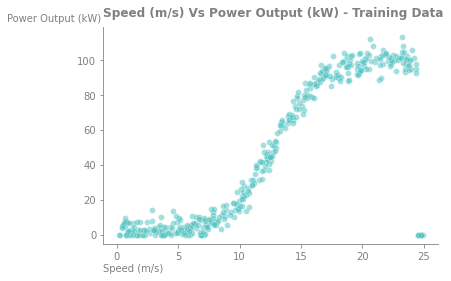

In [14]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x = X_train, y = y_train, alpha = 0.5, color = '#47C1BF')
format_plots(ax, 'Speed (m/s) Vs Power Output (kW) - Training Data')
ax;

Before we can fit a line to this, we'll need to work out what the slope (m) and y-intercept (c) would be. Fortunately, Numpy is able to quickly do this for us via the polyfit() function [6].

For this, I'll just need to provide the x variable (X_train), the y variable (y_train), and as we're looking for a line of best fit, the degree parameter will be set to 1. This polyfit() function will give us two values - the slope and the y-intercept. I can therefore assign these two outputs to two variables, m and c.

In [15]:
m,c = np.polyfit(X_train, y_train, 1)
print("m: " + str(m))
print("c: " + str(c))

m: 5.042768962220394
c: -15.129666438630068


Now that I have m and c, I can use these two values to plot my line. On the x axis, I'll simply have the X_train values. Meanwhile on the y axis, I'll be X_train by m, and adding c in order to generate the corresponding y values. This replicates the y=mx+c formula discussed previously.

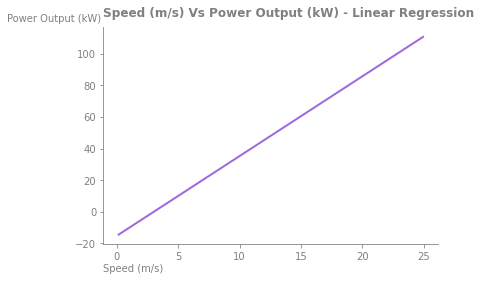

In [16]:
fig, ax = plt.subplots()
ax = sns.lineplot(x = X_train, y = X_train*m + c, color = '#9C6ADE', linewidth = 2)
format_plots(ax, 'Speed (m/s) Vs Power Output (kW) - Linear Regression')
ax;

We can see that the windspeed goes from 0 to 25m/s, just like our initial data set. The maximum y value is above 100kW, and as we know there is a value of 113kW in the real data set, this could be correct. However, when x is 0m/s, y is around -18kW. This can't possibly be correct, as our data set has 0kW as the lowest y value. So before we've compared this line to our data, there's already question marks over how effective this line will be.

I'll now plot it alongside the data points for closer inspection.

<AxesSubplot:>

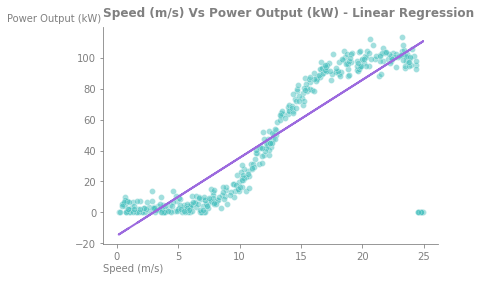

In [17]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x = X_train, y = y_train, alpha = 0.5, color = '#47C1BF')
format_plots(ax, 'Speed (m/s) Vs Power Output (kW) - Linear Regression')
ax.plot(X_train, X_train*m + c, color = '#9C6ADE', linewidth = 2)
ax

As we can see, this line might be the best fit for the data set as a whole, but it is limited in how effectively it shows the relationship between the data. We don't see the slow climb of energy generation until 7 m/s. We don't see just how quickly energy generation increases from 7m/s to 18m/s, and we don't see that power generation is capped around 100kW to 100kW. Therefore at no point other than the midpoint (when speed is around 12.5m/s) can we be confident that the y value is close to the true value. Also the fact it doesn't show that the power generation has a ceiling means that this line would keep giving higher and higher y values, even when the windspeed is at 50m/s which would lead to very misleading results.

I'll therefore need to find a way to fit a curve to this dataset, rather than a straight line. A polynomial regression will be my next step.

<a id='polynomial'></a>
## Poynomial Regression

While Linear Regression is effective when there is a straight linear relationship between the variables, it falls down when the relationship is non-uniform[7]. For example in our wind turbine dataset, we see that the power output increases more rapdily with increasing wind speed in some parts of the dataset when compared to others. In this situation, we can use a polynomial regression which will create a curve of best fit, rather than a straight line. 

While polynomial regression is more complex than linear regression, it can still be performed by using Numpy's polyfit()[8] like so:

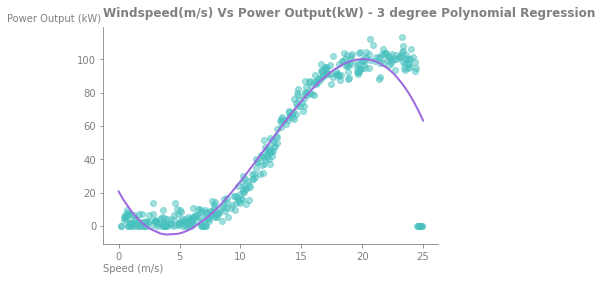

In [18]:
#Fitting the data to a 3rd degree polynomial regression.
poly_fit = np.poly1d(np.polyfit(X_train, y_train, 3))

fig, ax = plt.subplots()
format_plots(ax, 'Windspeed(m/s) Vs Power Output(kW) - 3 degree Polynomial Regression')

#Plotting the curve created by poly_fit.
plt.plot(np.sort(X_test, axis = 0), poly_fit(np.sort(X_test, axis = 0)), color = '#9C6ADE', linewidth = 2)

#Plotting the training data to show it fits the curve.
plt.scatter(X_train, y_train,  alpha = 0.5, color = '#47C1BF');

Already we can see that this curve better fits the data overall. There are still some questionable areas though, for example we see the curve starting with an output of 20kW when windpseed is at 0m/s, and it even dips below 0kW at around 4m/s. Therefore this curve is under-fitted.

### Under-Fitting and Over-Fitting

When creating and applying machine learning and similar models to a dataset, there are two key considerations that the user must keep in mind in order to ensure that their model is as resilient as can be - under-fitting and over-fitting. 

Under-fitting is when the model does not fit the data well enough, and thus provides inaccurate or inconsistent predictions for the user. This can happen if the dataset is particularly small, and thus there's not enough data for the model to be trained on. More commonly though, this will mean that the model is too simple or the data is too inconsistent, and so the model must either be tuned to be more precise (often via parameters or data pre-processing), or the dataset itself needs to be more thoroughly cleaned before analysis. 

The opposite issue is over-fitting. This is where the model fits the provided data too precisely, and while it may look perfect on the training data, it's actually just mapped to that data and thus struggles to accurately model new, unseen data. This is a big part of the reason why datasets are split into training and testing sets before they are modeled, as it allows the user to see how the model behaves on unseen data. If it performs brilliantly on the training set, but terribly on the testing set, then one can be sure their model is over-fitting. A first step to counter-acting this is to make the model a bit simpler, such as by reducing the values of certain parameters.

In polynomial regression, it's the degrees that can influence whether the data is underfit, overfit or just right, as each additional degree makes the model more complex. For example, if we increase the degrees to 8, we can see that the line starts from 0kW and begins to increase, rather than starting higher and dipping as shown in the 3 degrees plot above. We even see that the measurements of 0kW power output recorded after 24.5 m/s are affecting this model more than the 3 degrees plot.

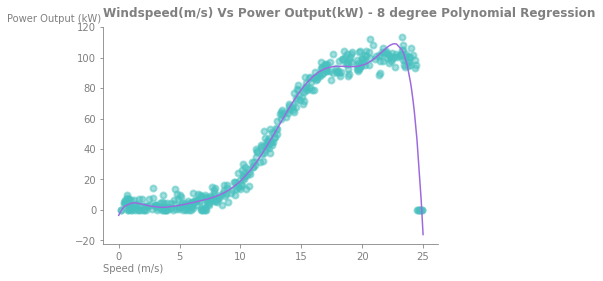

In [19]:
poly_fit = np.poly1d(np.polyfit(X_train, y_train, 8))

fig, ax = plt.subplots()
format_plots(ax, 'Windspeed(m/s) Vs Power Output(kW) - 8 degree Polynomial Regression')

plt.plot(np.sort(X_test, axis = 0), poly_fit(np.sort(X_test, axis = 0)), color = '#9C6ADE')
plt.scatter(X_train, y_train, alpha = 0.5, color = '#47C1BF', linewidth = 2 );

Similarly, if we increase the degrees to 14, we see the line fits the training dataset even more closely overall, however it plunges further below 0kW at 25m/s. This is likely due to over-fitting.

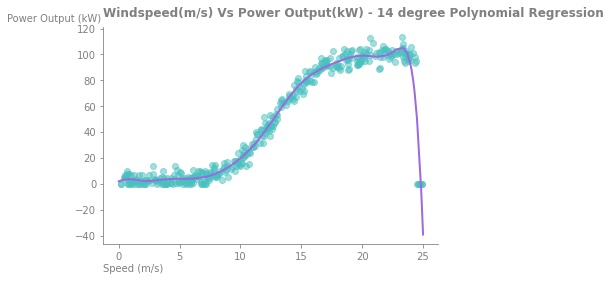

In [20]:
poly_fit = np.poly1d(np.polyfit(X_train, y_train, 14))

fig, ax = plt.subplots()
format_plots(ax, 'Windspeed(m/s) Vs Power Output(kW) - 14 degree Polynomial Regression')
plt.plot(np.sort(X_test, axis = 0), poly_fit(np.sort(X_test, axis = 0)), color = '#9C6ADE', linewidth = 2)
plt.scatter(X_train, y_train, alpha = 0.5, color = '#47C1BF');

In order to gauge the accuracy of these linear and polynomial regression models, I will first replicate them in Scikit-Learn (SKlearn). This will allow me to use the same accuracy metrics for each of the regression models I use. I will begin by reshaping my training and testing arrays to ensure they work with SKLearn.

In [21]:
#Getting an error as the linear regression is expecting a 2d array. Error message suggested reshapring them.
X_train = np.array(X_train).reshape(-1, 1)
y_train = np.array(y_train).reshape(-1, 1)

X_test = np.array(X_test).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

I can now fit a linear regression using SKlearn [10], and plot the results to show it is the same as what I achieved with Numpy previously.

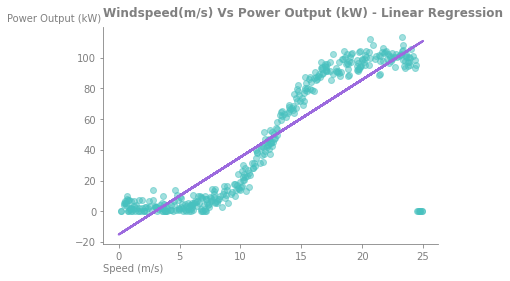

In [22]:
#Importing LinearRegression
from sklearn.linear_model import LinearRegression 

#Creating the LinearRegression object.
regr = LinearRegression() 

#Fitting the training data to create the model.
regr.fit(X_train, y_train) 

#Using the training model to predict what y_test would be.
linear_predictions = regr.predict(X_test)

# Visualising the Linear Regression results 
fig, ax = plt.subplots()
format_plots(ax, 'Windspeed(m/s) Vs Power Output (kW) - Linear Regression')
plt.scatter(X_train, y_train, alpha = 0.5, color = '#47C1BF')   
plt.plot(X_test, linear_predictions, color = '#9C6ADE', linewidth = 2);

In order to do a polynomial regression, I must use PolynomialFeatures from SKlearn's preprocessing[11], as suggested by Geeksforgeeks[12]. I'll first fit the 3 degree polynomial.

In [23]:
#Importing PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures 

#Setting the degrees to 3for the polynomial regression.
poly = PolynomialFeatures(degree = 3) 

#Standardizing the dataset[13].
X_poly = poly.fit_transform(X_train) 

#Fitting the model to the training data.
poly.fit(X_poly, y_train) 

#Creating the LinearRegression object.
poly_regr = LinearRegression() 

#Fitting the polynomial to a regression.
poly_regr.fit(X_poly, y_train) 

#Saving the predictions to a variable to test accuracy later.
polynomial_3_predictions = poly_regr.predict(poly.fit_transform(X_test))

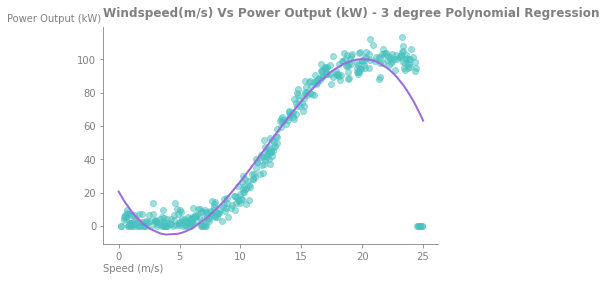

In [24]:
fig, ax = plt.subplots()
format_plots(ax, 'Windspeed(m/s) Vs Power Output (kW) - 3 degree Polynomial Regression')

# Visualising the Polynomial Regression results 
plt.scatter(X_train, y_train, alpha = 0.5, color = '#47C1BF') 

#As my X_test data is not sorted (it was picked at random), I must sort it when plotting in order to get a clean curve.
plt.plot(np.sort(X_test, axis = 0), poly_regr.predict(poly.fit_transform(np.sort(X_test, axis = 0))), color = '#9C6ADE', linewidth = 2) ;

I'll now fit higher degree polynomials as I showed with Numpy earlier. I will again test 8 degrees and 14th degrees, as adding more degrees requires more processing power, and thus longer delays. The time to process 14 degrees can already be measured in seconds, and so it already highlights one of the costs of overfitting. 

I will not plot these, but will save their predictions to variables so that I can compare accuracy.

In [25]:
#Setting the degrees to 8 for the polynomial regression.
poly = PolynomialFeatures(degree = 8) 

#Standardizing the dataset[13].
X_poly = poly.fit_transform(X_train) 

#Fitting the model to the training data.
poly.fit(X_poly, y_train) 

#Creating the LinearRegression object.
poly_regr = LinearRegression() 

#Fitting the polynomial to a regression.
poly_regr.fit(X_poly, y_train) 

#Saving the predictions to a variable to test accuracy later.
polynomial_8_predictions = poly_regr.predict(poly.fit_transform(X_test))

In [26]:
#Setting the degrees to 17 for the polynomial regression.
poly = PolynomialFeatures(degree = 14) 

#Standardizing the dataset[13].
X_poly = poly.fit_transform(X_train) 

#Fitting the model to the training data.
poly.fit(X_poly, y_train) 

#Creating the LinearRegression object.
poly_regr = LinearRegression() 

#Fitting the polynomial to a regression.
poly_regr.fit(X_poly, y_train) 

#Saving the predictions to a variable to test accuracy later.
polynomial_14_predictions = poly_regr.predict(poly.fit_transform(X_test))

<a id='performance'></a>
## Measuring model performance

In order to assess how each model is performing with regards to its predictions, we must use a model performance metric. For this, I will be using Mean Squared Error (MSE) and R-squared Error (R2)[14]. 

The Mean Squared Error is one of the more straightforward performance metrics in machine learning, as it squares the differences between the predicted values and actual values. Therefore regardless of how close the prediction might be, if its at all inaccurate it will still add to the score. Similarly larger inaccurate predictions will greatly influence the score too, and so MSE is a very sensitive score that lends itself well to comparing multiple models or tweaking the parameters of a given model, with the lower scores being the aim. 

R-squared, also known as the Coefficient of Determination, looks at the variance of the predictions compared to the actual results, and returns a percentage (or in the case of SKlearn, a floating number with a maximum of 1.0)[15]. The closer this score is to 100% (or 1.0), the closer the predictions and actual results are, with 100% being a perfect match. 

Between these two scores, I'll be able to see how often the model is correct (R-squared), and by how much it was incorrect (Mean Squared Error).

Here I'll be using the mean_squared_error[16] and r2_score[17] from sklearn.metrics. I will use these to calculate the MSE and R-Squared for each of the four regressions performed thus far; linear, 3 degree polynomial, 8 degree polynomial and 14 degree polynomial. This will allow me to compare the scores and their trade offs.

First, the linear regression and 3rd degree polynomial models.

In [27]:
from sklearn.metrics import mean_squared_error, r2_score

linear_mse = mean_squared_error(y_test, linear_predictions)
linear_r2 = r2_score(y_test, polynomial_3_predictions)

print("Linear Regression Mean Squared Error (MSE): ", linear_mse)
print("Linear Regression R2 Score: ", linear_r2)

Linear Regression Mean Squared Error (MSE):  575.0747989106513
Linear Regression R2 Score:  0.8812606496341394


In [28]:
polynomial_3_mse = mean_squared_error(y_test, polynomial_3_predictions)
polynomial_3_r2 = r2_score(y_test, polynomial_3_predictions)

print("3 Degree Polynomial Regression Mean Squared Error (MSE): ", polynomial_3_mse)
print("3 Degree Polynomial Regression R2 Score: ", polynomial_3_r2)

3 Degree Polynomial Regression Mean Squared Error (MSE):  206.10067429191426
3 Degree Polynomial Regression R2 Score:  0.8812606496341394


Surprisingly the R-squared score is exactly the same for both of these models. This tells us that they are accurate about the same amount of time. However, the Mean Squared Error has a huge difference, with the Linear Regression being more than double the 3rd degree polynomial. 

This means that although both are accurate for the same proportion of predictions, the linear model's estimates are incorrect by a higher margin. This isn't a surprise, as the linear model continues to slope upwards when windspeed is 25m/s, even though the output from 24.5m/s onwards is 0kW. This means that any data points after 24.5m/s will contribute heavily to the Mean Squared Error. Meanwhile the 3rd degree polynomial slopes somewhat downards at this point, and so that gap between the predicted value and the actual will be much smaller.

So far the 3rd degree polynomial model is the best fit then. How does this compare to the 8 degree and 14 degree polynomials.?

In [29]:
polynomial_8_mse = mean_squared_error(y_test, polynomial_8_predictions)
polynomial_8_r2 = r2_score(y_test, polynomial_8_predictions)

print("8 Degree Polynomial Regression Mean Squared Error (MSE): ", polynomial_8_mse)
print("8 Degree Polynomial Regression R2 Score: ", polynomial_8_r2)

8 Degree Polynomial Regression Mean Squared Error (MSE):  79.81510519632178
8 Degree Polynomial Regression R2 Score:  0.9540166776603026


In [30]:
polynomial_14_mse = mean_squared_error(y_test, polynomial_14_predictions)
polynomial_14_r2 = r2_score(y_test, polynomial_14_predictions)

print("14 Degree Polynomial Regression Mean Squared Error (MSE): ", polynomial_14_mse)
print("14 Degree Polynomial Regression R2 Score: ", polynomial_14_r2)

14 Degree Polynomial Regression Mean Squared Error (MSE):  77.71405739215498
14 Degree Polynomial Regression R2 Score:  0.9552271397425423


The R-Squared and Mean Squared Error both see dramatic improvements between the 3 degree polynomial and the 8 degree polynomial. There's then a slight improvement between the 8 degree and 14 degree polynomials.

While an accurate model is the aim here, we do also need to keep in mind how much processing power is required to run these models. On a small dataset of just 496 data points, the 14 degree polynomial already takes seconds to load. Were this model to be deployed and be faced with thousands or even millions of datapoints, it would surely be too slow and too demanding to be of use. It should also be noted that the improvement compared to the 8 degree polynomial is not dramatic, with the Mean Squared Error only reduced by 7.9. 

Therefore, despite it's greater accuracy, I will continue with the 8 degree polynomial as the leading model for now. The 14 degree polynomial is too big a jump in cost for too small an improvement.

<a id='tree'></a>
## Decision Tree Regression

Decision Trees are a common form of machine learning algorithm that can be used for regression and classification. They work much like a flow chart, and so the data point is compared to a specific criteria, and whether it meets or falls outside of that criteria decides the next step. The algorithm will keep comparing the data point to criteria until it finds a final placement that it deems most suitable[18]. This means that it can work very effectively on datasets that are not linearly related, such as the wind turbine dataset here. 

For example, in the polynomial regression models, we saw that the curve dipped towards 0kW after windspeed is 24.5m/s. While this does bring it closer to the actual measurements of 0kW output at this point, the model would still be making incorrect predictions as the curve declines. Due to the IF/ELSE nature of decision trees, a decision tree regression could set the condition that if the windspeed is about 24.5m/s, the output will be 0kW, and represent this with a straight drop in its line. As a result decision tree regression is less of a curve, and more of a series of straight lines, giving a blocky appearance.

I can agains use sklearn's DecisionTreeRegressor()[19] to conduct this regression. I'll then plot the results and take a look at the Mean Squared Error and R-Squared scores. For the decision tree regression, I will be editing the max_depth parameter to compare model performances, as I did with the degrees for the polynomial regression.

<AxesSubplot:>

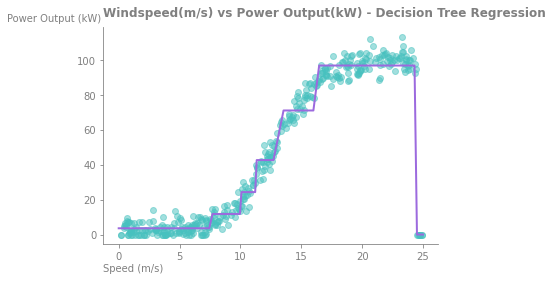

In [31]:
#Importing the decision tree from sklearn.
from sklearn import tree

#Creating the DecisionTreeRegressor object with max_depth 3.
clf = tree.DecisionTreeRegressor(max_depth=3)

#Fitting the training data.
clf = clf.fit(X_train, y_train)

# Predict the sorted y_test values for plotting and saving to a variable. 
tree_3_predictions_plot = clf.predict(np.sort(X_test, axis = 0))

# Plot the results
fig,ax = plt.subplots()
plt.scatter(X_train, y_train, alpha = 0.5, color = '#47C1BF')
plt.plot(np.sort(X_test, axis = 0), tree_3_predictions_plot, color = '#9C6ADE', linewidth = 2)
format_plots(ax, "Windspeed(m/s) vs Power Output(kW) - Decision Tree Regression")

I'll now compare the prediction results to the existing y_test values.

In [32]:
#Predicting the y_test values without sorting so that they can be compared.
tree_3_predictions = clf.predict(X_test)

In [33]:
tree_3_mse = mean_squared_error(y_test, tree_3_predictions)
tree_3_r2 = r2_score(y_test, tree_3_predictions)

print("Tree Regression Mean Squared Error (MSE): ", tree_3_mse)
print("Tree Regression Regression R2 Score: ", tree_3_r2)

Tree Regression Mean Squared Error (MSE):  30.955809370052542
Tree Regression Regression R2 Score:  0.9821656444973909


With the max_depth parameter set to 3, we're already seeing good results on the MSE and R2 scores, and we know that it is taking into account the drop to 0kW output after windspeed hits 24.5m/s.

Another advantage of decision tree models is that the decision tree itself can be visualized, thus informing the user of how it is making its decisions[20]. For example, in the below diagram, we can see that once X is greater than or equal to 24.462, the output will be 0.0kW. However, we do also see that when windspeed is at 7.567m/s or less, the lowest output value this model will predict is 3.603, not 0kW.

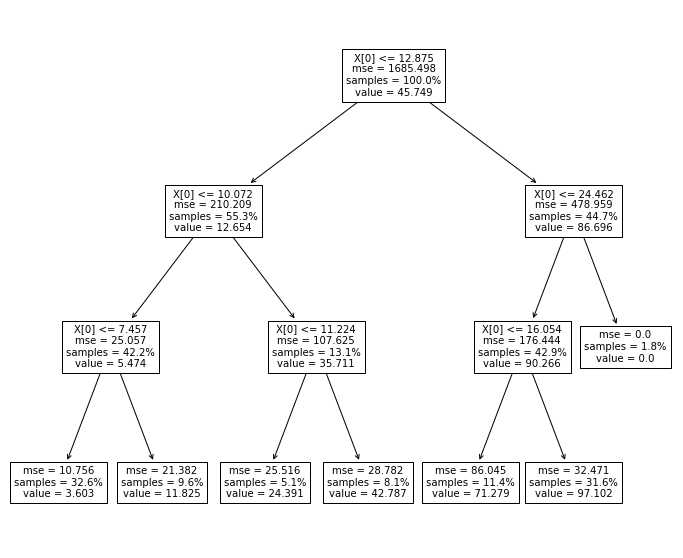

In [34]:
plt.figure(figsize = (12, 10))
tree.plot_tree(clf, proportion = True);

I'll now increase the max_depth parameter to 5 see if I can make it more accurate, without sacrificing too much performance.

In [35]:
#Creating the DecisionTreeRegressor object with max_depth 5.
clf = tree.DecisionTreeRegressor(max_depth=5)

#Fitting the training data.
clf = clf.fit(X_train, y_train)

# Predict the sorted y_test values for performance comparison. 
tree_5_predictions = clf.predict(X_test)

tree_5_mse = mean_squared_error(y_test, tree_5_predictions)
tree_5_r2 = r2_score(y_test, tree_5_predictions)

print("Tree Regression Mean Squared Error (MSE): ", tree_5_mse)
print("Tree Regression Regression R2 Score: ", tree_5_r2)

Tree Regression Mean Squared Error (MSE):  19.78807150482045
Tree Regression Regression R2 Score:  0.988599635767578


With max_depth set to 5, the MSE is down by about a third, and R2 has increased slightly. This is a notable improvement in performance, without too much overheard. I'll now see if a max_depth of 6 improves the results further.

In [36]:
#Creating the DecisionTreeRegressor object with max_depth 3.
clf = tree.DecisionTreeRegressor(max_depth=6)

#Fitting the training data.
clf = clf.fit(X_train, y_train)

# Predict the sorted y_test values for performance comparison. 
tree_5_predictions = clf.predict(X_test)

tree_5_mse = mean_squared_error(y_test, tree_5_predictions)
tree_5_r2 = r2_score(y_test, tree_5_predictions)

print("Tree Regression Mean Squared Error (MSE): ", tree_5_mse)
print("Tree Regression Regression R2 Score: ", tree_5_r2)

Tree Regression Mean Squared Error (MSE):  20.460760178255047
Tree Regression Regression R2 Score:  0.988212084313142


Now we've got an example of over-fitting. When max_depth is set to 6, the results are actually worse than they were at 5. The model is too complex at this point, and it's negatively impacting the results, while also being more computationally intensive. 

The decision tree regression with max_depth of 5 is already performming much better than the previous leading regression technique in this notebook - the 8 degree polynomial. The MSE of 19.79 is much lower than the 79.82 seen with the polynomial, and the R2 is more than 3% higher at 0.9882 compared to the 0.954 of the polynomial.

Therefore this decision tree regression is now the leading model.

<a id='knn'></a>
## K Nearest Neighbors Regression

K Nearest Neighbors (KNN) is a machine learning algorithm that looks at the data points most similar to the one that is being predicted, and determines the answer from there. KNN is regularly used for classification whereby it will determine what category an observation should be assigned to based on the similiarity of its variables with those of other observations, but it can also be used for regression. In the case of regression, the KNN algorithm will take the values of the "k" nearest data poins and calculate the average as its prediction[21].

When using KNN algorithms, the "k" value will determine how many nearby data points are taken into account. This means that getting "k" right is crucial to ensuring the dataset is not underfitted or overfitted. If "k" is too low, then each prediction is based off too few datapoints, meaning outliers or other sudden changes in the data can have a strong impact. Meanwhile a "k" that is too high becomes overfitted, and may struggle to adapt to unseen data.

When using KNN algorithms in SKLearn, the user can also specify how they wish each of the "k" points to be weighted[22]. The default setting is for these to be treated uniformly, so if "k" is set to 3, all three points carry the same weight. However, the user can change the "weighting" parameter to "distance". This will ensure that the points closests to the one being predicted carry more weight in the prediction. This will likely be a factor in the wind turbine dataset, as the output abruptly drops to 0kW at 24.5m/s. By having the weighting set to "distance", the algorithm should recognise that drop off more quickly than when they are weighted uniformly.

I will first try KNN with uniform weighting[23], followed by weighting set to "distance".

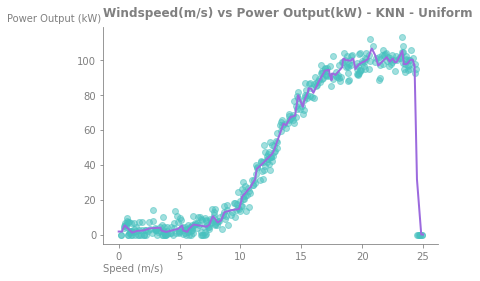

In [37]:
#Importing neighbors from SKLearn.
from sklearn import neighbors

#Setting n_neighbors to 3.
n_neighbors = 3

#Creating the KNeighborsRegressor object, with weights set to "uniform".
knn = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')


knn_3_uniform_predictions_plot = knn.fit(X_train, y_train).predict((np.sort(X_test, axis = 0)))

fig, ax = plt.subplots()
plt.scatter(X_train, y_train, alpha = 0.5, color = '#47C1BF')
plt.plot(np.sort(X_test, axis = 0), knn_3_uniform_predictions_plot, color = '#9C6ADE', linewidth = 2)
format_plots(ax, "Windspeed(m/s) vs Power Output(kW) - KNN - Uniform");

In [38]:
knn_3_uniform_predictions = knn.fit(X_train, y_train).predict(X_test)

And now I'll add another KNN with weighting set to "distance".

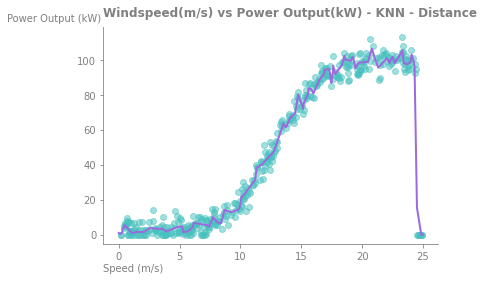

In [39]:
n_neighbors = 3

knn = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')
knn_3_distance_predictions_plot = knn.fit(X_train, y_train).predict(np.sort(X_test, axis = 0))

fig, ax = plt.subplots()
plt.scatter(X_train, y_train, alpha = 0.5, color = '#47C1BF')
plt.plot(np.sort(X_test, axis = 0), knn_3_distance_predictions_plot, color = '#9C6ADE', linewidth = 2)
format_plots(ax, "Windspeed(m/s) vs Power Output(kW) - KNN - Distance");

In [40]:
knn_3_distance_predictions = knn.fit(X_train, y_train).predict(X_test)

In [41]:
knn_3_uniform_mse = mean_squared_error(y_test, knn_3_uniform_predictions)
knn_3_uniform_r2 = r2_score(y_test, knn_3_uniform_predictions)

knn_3_distance_mse = mean_squared_error(y_test, knn_3_distance_predictions)
knn_3_distance_r2 = r2_score(y_test, knn_3_distance_predictions)

print("KNN 3 (Uniform) Regression Mean Squared Error (MSE): ", knn_3_uniform_mse)
print("KNN 3 (Uniform) Regression Regression R2 Score: ", knn_3_uniform_r2)
print("KNN 3 (Distance) Regression Mean Squared Error (MSE): ", knn_3_distance_mse)
print("KNN 3 (Distance) Regression Regression R2 Score: ", knn_3_distance_r2)

KNN 3 (Uniform) Regression Mean Squared Error (MSE):  34.03424294777779
KNN 3 (Uniform) Regression Regression R2 Score:  0.9803920879361647
KNN 3 (Distance) Regression Mean Squared Error (MSE):  27.74101779419574
KNN 3 (Distance) Regression Regression R2 Score:  0.984017760045243


The K-Nearest Neighbors with weighting set to "distance" is slightly outperforming the default "uniform" setting. There's not much in it, but it's a slight improvement.

I've tried a few values for "k", ranging from 2 to 20, and this is the best performance I've been able to get. Therefore this KNN regression algorithm isn't quite as accurate as the previous Decision Tree Regression, as the MSE is higher and the R2 is a shade lower.

In [42]:
print("Tree Regression Mean Squared Error (MSE): ", tree_5_mse)
print("Tree Regression Regression R2 Score: ", tree_5_r2)
print("KNN 3 (Distance) Regression Mean Squared Error (MSE): ", knn_3_distance_mse)
print("KNN 3 (Distance) Regression Regression R2 Score: ", knn_3_distance_r2)

Tree Regression Mean Squared Error (MSE):  20.460760178255047
Tree Regression Regression R2 Score:  0.988212084313142
KNN 3 (Distance) Regression Mean Squared Error (MSE):  27.74101779419574
KNN 3 (Distance) Regression Regression R2 Score:  0.984017760045243


## Conclusion

In this Jupyter Notebook, I've analyzed the wind turbine power output data set (turbine_output.csv) by applying four types of regression analyses:
* Linear regression
* Polynomial regression
* Decision Tree regresion
* K-Nearest Neighbors regression

Through these analyses, I've found that a decision tree regression with the max_depth parameter set to 5 produced the most accurate results, with an R2 score of 98.82% and an Mean Squared Error of just 20.46. This meant that this type of regression was not only correct with its predictions more often, but its inaccurate predictions were closer to the true result too.

You can see the line fitted to the dataset below.

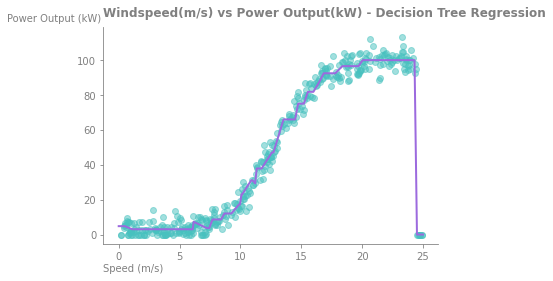

In [43]:
#Creating the DecisionTreeRegressor object with max_depth 5.
clf = tree.DecisionTreeRegressor(max_depth = 5)

#Fitting the training data.
clf = clf.fit(X_train, y_train)

# Predict the sorted y_test values for plotting and saving to a variable. 
tree_5_predictions_plot = clf.predict(np.sort(X_test, axis = 0))

fig,ax = plt.subplots()
plt.scatter(X_train, y_train, alpha = 0.5, color = '#47C1BF')
plt.plot(np.sort(X_test, axis = 0), tree_5_predictions_plot, color = '#9C6ADE', linewidth = 2)
format_plots(ax, "Windspeed(m/s) vs Power Output(kW) - Decision Tree Regression");

Despite this higher accuracy and lower margin of error this model is not perfect. We can see when windspeed is between 0m/s and 5m/s in particular, as the lowest estimate this model will make here is an output of 3.05264516kW, even though one would expect when windspeed is at 0m/s, output will be at 0kW. It should be noted that at this end of the dataset, the data is particularly noisy. For example when windpseed is between 0m/s and 1m/s the output measurements vary from 0kW to 9.746kW, and as this decision tree regressor takes the average value of each "leaf" for its prediction, these varied recordings mean a measurement of 0kW will not be made.

In [44]:
#Prediction output when windspeed is 0m/s.
clf.predict([[0]])

array([4.8244])

Contrast this with the predictions after 24.5m/s, where output measurements are consistently at 0kW and we see the model accurately predicting the 0kW output.

In [45]:
#Prediction output when windspeed is 24.5m/s.
clf.predict([[24.5]])

array([0.])

With just 496 observations (the original 500 minus the 4 observations I deemed to be outliers), the dataset is still fairly small for training these regression algorithms. As more observations are recorded, we can expect this model to become more accurate, and this may improve its predicitons at lower windspeeds. For now though, with the dataset we have to hand, and the regression analyses I have performed here, this Decision Tree regression performs the best.

# Notes

To-do: 
* Tidy references
* Spelling & Grammar check

<a id='references'></a>

# Resources & References

<br>[1] https://www.statisticshowto.com/probability-and-statistics/data-analysis/#EDA
<br>[2] https://stackoverflow.com/questions/52456874/drop-rows-on-multiple-conditions-in-pandas-dataframe
<br>[3] https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/
<br>[4] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
<br>[5] https://joshualoftus.com/posts/2020-11-23-least-squares-as-springs/
<br>[6] https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
<br>[7] https://www.analyticsvidhya.com/blog/2020/03/polynomial-regression-python/
<br>[8] https://pythonbasics.org/polynomial-regression-in-python/
<br>[9] https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/
<br>[10] https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py
<br>[11] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
<br>[12] https://www.geeksforgeeks.org/python-implementation-of-polynomial-regression/
<br>[13] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
<br>[14] https://towardsdatascience.com/regression-an-explanation-of-regression-metrics-and-what-can-go-wrong-a39a9793d914
<br>[15] https://www.bmc.com/blogs/mean-squared-error-r2-and-variance-in-regression-analysis/
<br>[16] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
<br>[17] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
<br>[18] https://kashishchugh.medium.com/decision-tree-regression-in-machine-learning-4f117158cdcc
<br>[19] https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html
<br>[20] https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
<br>[21] https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/
<br>[22] https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
<br>[23] https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html#sphx-glr-auto-examples-neighbors-plot-regression-py